In [1]:
from keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout, concatenate, LSTM, Add, Multiply, Layer
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
import numpy as np
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.utils import plot_model
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from utils import *
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


In [2]:
H = K.constant([[1, 1]])
SNR1 = 7
SNR2 = 7
SNRs = [SNR1, SNR2]
ebno = [calc_ebno(SNR) for SNR in SNRs]

k = 2
n_channel = 2
M = 2 ** k
k = int(k)
R = k / n_channel

In [23]:
input_signal1 = Input(shape=(M,), name="input1")
input_signal2 = Input(shape=(M,), name="input2")
encoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="encoder1")
encoder2 = Sequential([
    Dense(M, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="encoder2")

combiner = Sequential([
    Dense(n_channel, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="combiner")

signal_input1 = Sequential(
    [Lambda(TransmissionLayer, arguments={"t":0, "k":0}),
    GaussianNoise(np.sqrt(1 / (2 * R * ebno[0])))], name="transmit1"
)

signal_input2 = Sequential(
    [Lambda(TransmissionLayer, arguments={"t":0, "k":1}),
    GaussianNoise(np.sqrt(1 / (2 * R * ebno[1])))], name="transmit2")

decoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder1")

decoder2 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder2")

In [12]:
x1 = encoder1(input_signal1)
x2 = encoder2(input_signal2)
x = concatenate([x1, x2], axis=1)
x = combiner(x)
x1 = signal_input1(x)
x2 = signal_input2(x)
out1 = decoder1(x1)
out2 = decoder2(x2)

model = Model(inputs=[input_signal1, input_signal2], outputs=[out1, out2])
model.summary()
alpha = K.variable(.5)

model.compile(optimizer="adam", loss=["categorical_crossentropy", "categorical_crossentropy"],
            loss_weights=[alpha, (1 - alpha)], metrics=["accuracy", BER])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
encoder1 (Sequential)           (None, 2)            30          input1[0][0]                     
__________________________________________________________________________________________________
encoder2 (Sequential)           (None, 2)            30          input2[0][0]                     
____________________________________________________________________________________________

In [15]:
train_datas = generate_train_datas()

model.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="loss", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    AlphaCallback(alpha)
])

Train on 200000 samples, validate on 200000 samples
Epoch 1/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2873 - decoder2_loss: 0.2862 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0265 - val_decoder1_loss: 0.0266 - val_decoder2_loss: 0.0265 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 2/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2876 - decoder2_loss: 0.2851 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0262 - val_decoder1_loss: 0.0256 - val_decoder2_loss: 0.0268 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 3/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.

200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2852 - decoder2_loss: 0.2856 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0268 - val_decoder1_loss: 0.0269 - val_decoder2_loss: 0.0267 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 40/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2875 - decoder2_loss: 0.2847 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0272 - val_decoder1_loss: 0.0272 - val_decoder2_loss: 0.0272 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 41/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2859 - decoder2_loss: 0.2863 - decoder1_acc: 0.8834 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2856 - decoder2_loss: 0.2866 - decoder1_acc: 0.8841 - decoder1_BER: 0.0580 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0279 - val_decoder1_loss: 0.0282 - val_decoder2_loss: 0.0276 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 78/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2854 - decoder2_loss: 0.2864 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8830 - decoder2_BER: 0.0585 - val_loss: 0.0278 - val_decoder1_loss: 0.0280 - val_decoder2_loss: 0.0277 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 79/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2874 - decoder2_loss: 0.2862 - decoder1_acc: 0.8822 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2886 - decoder2_loss: 0.2851 - decoder1_acc: 0.8820 - decoder1_BER: 0.0590 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0282 - val_decoder1_loss: 0.0281 - val_decoder2_loss: 0.0284 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 116/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2855 - decoder2_loss: 0.2867 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8831 - decoder2_BER: 0.0584 - val_loss: 0.0281 - val_decoder1_loss: 0.0283 - val_decoder2_loss: 0.0279 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 117/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2878 - decoder1_loss: 0.2882 - decoder2_loss: 0.2874 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2871 - decoder1_loss: 0.2856 - decoder2_loss: 0.2886 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.0285 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 154/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2880 - decoder2_loss: 0.2852 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0284 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 155/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2875 - decoder1_loss: 0.2884 - decoder2_loss: 0.2866 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2848 - decoder1_loss: 0.2847 - decoder2_loss: 0.2850 - decoder1_acc: 0.8833 - decoder1_BER: 0.0584 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0285 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 192/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2858 - decoder1_loss: 0.2869 - decoder2_loss: 0.2846 - decoder1_acc: 0.8823 - decoder1_BER: 0.0588 - decoder2_acc: 0.8841 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 193/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2877 - decoder2_loss: 0.2862 - decoder1_acc: 0.8832 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2858 - decoder2_loss: 0.2862 - decoder1_acc: 0.8835 - decoder1_BER: 0.0583 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 230/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2873 - decoder2_loss: 0.2866 - decoder1_acc: 0.8832 - decoder1_BER: 0.0584 - decoder2_acc: 0.8828 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 231/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2868 - decoder2_loss: 0.2864 - decoder1_acc: 0.8832 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2861 - decoder2_loss: 0.2862 - decoder1_acc: 0.8829 - decoder1_BER: 0.0585 - decoder2_acc: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 268/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2862 - decoder2_loss: 0.2861 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 269/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2865 - decoder1_loss: 0.2869 - decoder2_loss: 0.2861 - decoder1_acc: 0.8825 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2874 - decoder2_loss: 0.2871 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 306/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2847 - decoder2_loss: 0.2855 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 307/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2865 - decoder2_loss: 0.2854 - decoder1_acc: 0.8831 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2884 - decoder2_loss: 0.2832 - decoder1_acc: 0.8821 - decoder1_BER: 0.0590 - decoder2_acc: 0.8848 - decoder2_BER: 0.0576 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 344/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2867 - decoder2_loss: 0.2861 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 345/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2877 - decoder2_loss: 0.2856 - decoder1_acc: 0.8822 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2848 - decoder1_loss: 0.2851 - decoder2_loss: 0.2845 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 382/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2877 - decoder2_loss: 0.2849 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8835 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 383/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2880 - decoder2_loss: 0.2864 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2867 - decoder2_loss: 0.2864 - decoder1_acc: 0.8827 - decoder1_BER: 0.0587 - decoder2_acc: 0.8839 - decoder2_BER: 0.0581 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 420/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2876 - decoder2_loss: 0.2864 - decoder1_acc: 0.8833 - decoder1_BER: 0.0583 - decoder2_acc: 0.8837 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 421/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2869 - decoder2_loss: 0.2885 - decoder1_acc: 0.8826 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2864 - decoder2_loss: 0.2854 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 458/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2874 - decoder2_loss: 0.2849 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 459/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2853 - decoder2_loss: 0.2870 - decoder1_acc: 0.8833 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2850 - decoder1_loss: 0.2864 - decoder2_loss: 0.2837 - decoder1_acc: 0.8832 - decoder1_BER: 0.0584 - decoder2_acc: 0.8846 - decoder2_BER: 0.0577 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 496/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2865 - decoder2_loss: 0.2857 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 497/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2852 - decoder1_loss: 0.2860 - decoder2_loss: 0.2843 - decoder1_acc: 0.8825 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2855 - decoder1_loss: 0.2872 - decoder2_loss: 0.2837 - decoder1_acc: 0.8823 - decoder1_BER: 0.0588 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 534/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2863 - decoder2_loss: 0.2871 - decoder1_acc: 0.8835 - decoder1_BER: 0.0583 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 535/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2848 - decoder2_loss: 0.2863 - decoder1_acc: 0.8834 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2872 - decoder2_loss: 0.2864 - decoder1_acc: 0.8827 - decoder1_BER: 0.0586 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 572/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2834 - decoder2_loss: 0.2884 - decoder1_acc: 0.8846 - decoder1_BER: 0.0577 - decoder2_acc: 0.8825 - decoder2_BER: 0.0588 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 573/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2866 - decoder2_loss: 0.2859 - decoder1_acc: 0.8830 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2843 - decoder2_loss: 0.2883 - decoder1_acc: 0.8842 - decoder1_BER: 0.0579 - decoder2_acc: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 610/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2858 - decoder2_loss: 0.2850 - decoder1_acc: 0.8829 - decoder1_BER: 0.0586 - decoder2_acc: 0.8835 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 611/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2879 - decoder2_loss: 0.2853 - decoder1_acc: 0.8821 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2849 - decoder2_loss: 0.2854 - decoder1_acc: 0.8841 - decoder1_BER: 0.0580 - decoder2_acc: 0.8838 - decoder2_BER: 0.0581 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 648/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2863 - decoder2_loss: 0.2863 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8829 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 649/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2860 - decoder2_loss: 0.2863 - decoder1_acc: 0.8838 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2867 - decoder2_loss: 0.2835 - decoder1_acc: 0.8829 - decoder1_BER: 0.0585 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 686/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2850 - decoder1_loss: 0.2843 - decoder2_loss: 0.2857 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 687/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2875 - decoder1_loss: 0.2882 - decoder2_loss: 0.2867 - decoder1_acc: 0.8822 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2848 - decoder2_loss: 0.2867 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8831 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 724/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2856 - decoder2_loss: 0.2870 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8833 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 725/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2844 - decoder2_loss: 0.2876 - decoder1_acc: 0.8839 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2856 - decoder2_loss: 0.2856 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 762/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2844 - decoder1_loss: 0.2836 - decoder2_loss: 0.2851 - decoder1_acc: 0.8850 - decoder1_BER: 0.0575 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 763/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2860 - decoder2_loss: 0.2865 - decoder1_acc: 0.8835 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2868 - decoder2_loss: 0.2850 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 800/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2862 - decoder2_loss: 0.2874 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8827 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 801/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2850 - decoder2_loss: 0.2861 - decoder1_acc: 0.8838 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2852 - decoder2_loss: 0.2880 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8827 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 838/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2851 - decoder2_loss: 0.2857 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 839/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2883 - decoder2_loss: 0.2856 - decoder1_acc: 0.8826 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2874 - decoder2_loss: 0.2852 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8845 - decoder2_BER: 0.0577 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 876/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2872 - decoder2_loss: 0.2843 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 877/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2872 - decoder2_loss: 0.2866 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2848 - decoder2_loss: 0.2877 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8823 - decoder2_BER: 0.0589 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 914/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2881 - decoder1_loss: 0.2893 - decoder2_loss: 0.2869 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 915/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2879 - decoder2_loss: 0.2855 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2851 - decoder2_loss: 0.2885 - decoder1_acc: 0.8836 - decoder1_BER: 0.0582 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 952/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2864 - decoder2_loss: 0.2856 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8831 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 953/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2851 - decoder2_loss: 0.2903 - decoder1_acc: 0.8834 - decoder

KeyboardInterrupt: 

# Experiment 2
Train autoencoder first, then train combiner and decoder only

In [ ]:
seed_everything(21)
input_signal1 = Input(shape=(M,), name="input1")

encoder1 = create_encoder([M, n_channel], name="encoder1", activations=["relu", "linear"])
signal_input1 = create_inputs(R=R, H=H, t=0, k=0, ebno=ebno[0], name="transmit1")
decoder1 = create_decoder([M, M, M], name="decoder1", activation="relu")

x1 = encoder1(input_signal1)
x1 = signal_input1(x1)
out1 = decoder1(x1)

model1 = Model(inputs=input_signal1, outputs=out1)

model1.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", BER])

train_datas = generate_train_datas(k=1)

model1.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="BER", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.7, patience=20),
])

bers = ber_curve(encoder1, decoder1, R = R, SNR_range = [-10, 20], M=M)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 200000 samples, validate on 200000 samples
Epoch 1/2000
200000/200000 [==============================] - 1s 4us/step - loss: 1.2413 - accuracy: 0.1581 - BER: 0.2519 - val_loss: 1.3949 - val_accuracy: 0.2508 - val_BER: 0.2500
Epoch 2/2000
200000/200000 [==============================] - 0s 2us/step - loss: 1.1664 - accuracy: 0.3974 - BER: 0.2511 - val_loss: 1.3440 - val_accuracy: 0.2508 - val_BER: 0.2500
Epoch 3/2000
200000/200000 [==============================] - 0s 2us/step - loss: 1.1024 - accuracy: 0.5036 - BER: 0.2504 - val_loss: 1.2750 - val_accuracy: 0.2508 - val_BER: 0.2500
Epoch 4/2000
200000/200000 [==============================] - 0s 2us/step - loss: 1.0402 - accuracy: 0.6012 - BER: 0.2409 - val_loss: 1.2060 - val_accuracy: 0.5003 - val_BER: 0.2500
Epoch 5/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.9837 - accuracy: 0.6769 - BER: 0.1990 - val_loss: 1.1

Epoch 41/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.1364 - accuracy: 0.9972 - BER: 0.0017 - val_loss: 0.1207 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 42/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.1311 - accuracy: 0.9974 - BER: 0.0015 - val_loss: 0.1167 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 43/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.1259 - accuracy: 0.9976 - BER: 0.0013 - val_loss: 0.1128 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 44/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.1213 - accuracy: 0.9978 - BER: 0.0013 - val_loss: 0.1091 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 45/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.1167 - accuracy: 0.9980 - BER: 0.0011 - val_loss: 0.1055 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 46/2000
200000/200000 [==============================] - 0s

200000/200000 [==============================] - 0s 2us/step - loss: 0.0317 - accuracy: 0.9984 - BER: 7.8125e-04 - val_loss: 0.0266 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 85/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0310 - accuracy: 0.9983 - BER: 8.3500e-04 - val_loss: 0.0256 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 86/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0304 - accuracy: 0.9981 - BER: 9.4500e-04 - val_loss: 0.0247 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 87/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0287 - accuracy: 0.9985 - BER: 7.4000e-04 - val_loss: 0.0238 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 88/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0279 - accuracy: 0.9985 - BER: 7.6125e-04 - val_loss: 0.0229 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 89/2000
200000/200000 [==============================

Epoch 127/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0101 - accuracy: 0.9982 - BER: 9.1375e-04 - val_loss: 0.0051 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 128/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0095 - accuracy: 0.9984 - BER: 7.9125e-04 - val_loss: 0.0050 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 129/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0094 - accuracy: 0.9985 - BER: 7.6375e-04 - val_loss: 0.0048 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 130/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0091 - accuracy: 0.9985 - BER: 7.3250e-04 - val_loss: 0.0046 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 131/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0089 - accuracy: 0.9985 - BER: 7.3125e-04 - val_loss: 0.0044 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 132/2000
200000/200000 [==========

Epoch 170/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0056 - accuracy: 0.9985 - BER: 7.4500e-04 - val_loss: 0.0010 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 171/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0056 - accuracy: 0.9984 - BER: 7.9250e-04 - val_loss: 0.0010 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 172/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0058 - accuracy: 0.9984 - BER: 8.0125e-04 - val_loss: 9.7398e-04 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 173/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0055 - accuracy: 0.9984 - BER: 8.1625e-04 - val_loss: 9.4512e-04 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 174/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0057 - accuracy: 0.9984 - BER: 7.9500e-04 - val_loss: 9.1202e-04 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 175/2000
200000/200000

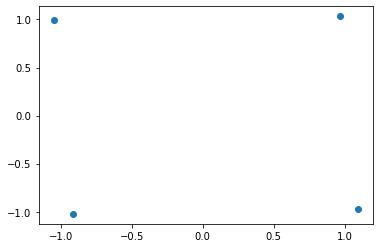

In [16]:
plot_scatter_constellation(encoder1)

In [17]:
rate_curve([bers])

array([0.4553 , 0.48205, 0.51239, 0.54274, 0.58083, 0.62365, 0.66313,
       0.70868, 0.75749, 0.80643, 0.84967, 0.89367, 0.92832, 0.95486,
       0.97571, 0.98845, 0.99527, 0.99853, 0.99955, 0.99997, 1.     ,
       1.     , 1.     , 1.     , 1.     , 1.     , 1.     , 1.     ,
       1.     , 1.     ])

In [19]:
decoder1.summary()

Model: "decoder1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_39 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 20        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [26]:
decoder1.summary()

Model: "decoder1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 20        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [5]:
def experiment(seed):
    seed_everything(seed)
    input_signal1 = Input(shape=(M,), name="input1")
    input_signal2 = Input(shape=(M,), name="input2")
    encoder1 = Sequential([
        Dense(M, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="encoder1")
    encoder2 = Sequential([
        Dense(M, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="encoder2")

    combiner = Sequential([
        Dense(n_channel, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="combiner")

    signal_input1 = Sequential(
        [Lambda(TransmissionLayer, arguments={"t":0, "k":0}),
        GaussianNoise(np.sqrt(1 / (2 * R * ebno[0])))], name="transmit1")

    signal_input2 = Sequential(
        [Lambda(TransmissionLayer, arguments={"t":0, "k":1}),
        GaussianNoise(np.sqrt(1 / (2 * R * ebno[1])))], name="transmit2")

    decoder1 = Sequential([
        Dense(M, activation="relu"),
        Dense(M, activation="relu"),
        Dense(M, activation="softmax")
    ], name="decoder1")

    decoder2 = Sequential([
        Dense(M, activation="relu"),
        Dense(M, activation="relu"),
        Dense(M, activation="softmax")
    ], name="decoder2")
    x1 = encoder1(input_signal1)
    x1 = signal_input1(x1)
    out1 = decoder1(x1)

    model1 = Model(inputs=input_signal1, outputs=out1)
    alpha = K.variable(.5)

    model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", BER])
    train_datas = generate_train_datas(k=1)

    model1.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
        epochs=2000, callbacks=[
        EarlyStopping(patience=100, restore_best_weights=True, monitor="BER", mode="min"),
        ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    ])
    
    bers = ber_curve(encoder1, decoder1, R = R, SNR_range = [-10, 20], M=M)
    
    return rate_curve([bers], R=R)

In [7]:
file_name = "rates.txt"
for seed in range(50):
    rate = experiment(seed)
    with open(file_name, "a+") as f:
        f.write("{} seed - rate {}\n\n".format(seed, rate))

================] - 0s 2us/step - loss: 0.0046 - accuracy: 0.9984 - BER: 7.8750e-04 - val_loss: 9.0752e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 191/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0045 - accuracy: 0.9986 - BER: 7.0000e-04 - val_loss: 8.9063e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 192/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0051 - accuracy: 0.9983 - BER: 8.5250e-04 - val_loss: 8.7940e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 193/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0049 - accuracy: 0.9985 - BER: 7.5625e-04 - val_loss: 8.6259e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 194/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0053 - accuracy: 0.9982 - BER: 8.7500e-04 - val_loss: 8.4533e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 195/2000
200000/200000 [==============================] - 

KeyboardInterrupt: 

In [29]:
hebe

NameError: name 'hebe' is not defined

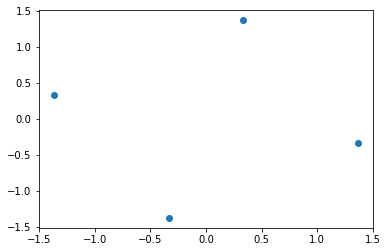

In [41]:
plot_scatter_constellation(encoder1)